# AE2b
## Adrian Zaręba | 320672

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import math

<style>
  h1, h2, h3, h4 {
    color: #458dc8;
  }
</style>

## Algorytm Genetyczny do Optymalizacji Rozmieszczenia Prostokątów w Okręgu

### Schemat działania algorytmu

1. **Inicjalizacja populacji**:
   - Tworzymy początkową populację losowo wygenerowanych rozwiązań.
   - Prostokąty są sortowane według stosunku wartości do pola (malejąco).
   - Każdy osobnik w populacji jest generowany przez losowe umieszczanie prostokątów w okręgu.

2. **Ocena populacji**:
   - Każde rozwiązanie (osobnik) jest oceniane pod kątem swojej wartości.
   - Ocena uwzględnia wartość prostokątów, sprawdza czy mieszczą się one w okręgu i nie kolidują ze sobą.

3. **Selekcja**:
   - Wybieramy najlepsze rozwiązania do kolejnej generacji.
   - Najlepsza połowa populacji przechodzi do następnej rundy.

4. **Krzyżowanie i mutacja**:
   - Tworzymy nowe rozwiązania poprzez krzyżowanie wybranych osobników i stosowanie mutacji.
   - Krzyżowanie łączy cechy dwóch rodziców, tworząc potomstwo.
   - Mutacja wprowadza losowe zmiany w rozwiązaniach, np. dodanie nowego prostokąta, usunięcie istniejącego, zmiana pozycji lub orientacji prostokąta.

5. **Iteracja**:
   - Proces jest powtarzany przez określoną liczbę generacji.
   - W każdej generacji populacja jest oceniana, selekcjonowana, krzyżowana i mutowana.

6. **Zakończenie**:
   - Po zakończeniu iteracji wybierane jest najlepsze znalezione rozwiązanie.
   - Najlepsze rozwiązanie jest wizualizowane na wykresie, pokazując optymalne rozmieszczenie prostokątów w okręgu.
## Uruchomienie algorytmu

In [31]:
# Obliczenie stosunku wartości do pola prostokąta
def value_to_area_ratio(rectangle):
    width, height, value = rectangle
    area = width * height
    return value / area


# Inicjalizacja populacji
def initialize_population(pop_size, rectangles, circle_radius):
    # Sortowanie prostokątów według stosunku wartości do pola (malejąco)
    rectangles = sorted(rectangles, key=value_to_area_ratio, reverse=True)
    population = []
    for _ in range(pop_size):
        num_rectangles = random.randint(1, len(rectangles))
        individual = []
        for _ in range(num_rectangles):
            width, height, value = random.choice(rectangles)
            x = random.uniform(-circle_radius, circle_radius)
            y = random.uniform(-circle_radius, circle_radius)
            orientation = random.choice(['horizontal', 'vertical'])
            individual.append((x, y, width, height, orientation, value))
        population.append(individual)
    return population


# Sprawdzenie kolizji prostokątów
def check_collision(rect1, rect2):
    x1, y1, w1, h1, orientation1, _ = rect1
    x2, y2, w2, h2, orientation2, _ = rect2
    if orientation1 == 'vertical':
        w1, h1 = h1, w1
    if orientation2 == 'vertical':
        w2, h2 = h2, w2
    if (x1 - w1/2 < x2 + w2/2 and x1 + w1/2 > x2 - w2/2 and
        y1 - h1/2 < y2 + h2/2 and y1 + h1/2 > y2 - h2/2):
        return True
    return False


# Sprawdzenie czy prostokąt mieści się w kole
def inside_circle(x, y, w, h, orientation, circle_radius):
    if orientation == 'vertical':
        w, h = h, w
    return (x - w/2)**2 + (y - h/2)**2 <= circle_radius**2 and \
           (x + w/2)**2 + (y - h/2)**2 <= circle_radius**2 and \
           (x - w/2)**2 + (y + h/2)**2 <= circle_radius**2 and \
           (x + w/2)**2 + (y + h/2)**2 <= circle_radius**2


# Funkcja oceny rozwiązania
def evaluate(individual, circle_radius):
    value_sum = 0
    for i, rect1 in enumerate(individual):
        x1, y1, w1, h1, orientation1, value1 = rect1
        if orientation1 == 'vertical':
            w1, h1 = h1, w1
        # Sprawdzenie czy prostokąt mieści się w kole
        if not inside_circle(x1, y1, w1, h1, orientation1, circle_radius):
            continue
        # Sprawdzenie kolizji z innymi prostokątami
        collision = False
        for j, rect2 in enumerate(individual):
            if i != j and check_collision(rect1, rect2):
                collision = True
                break
        if not collision:
            value_sum += value1
    return value_sum


# Funkcja szukająca pozycji blisko środka
def find_position_near_center(width, height, orientation, mutated, circle_radius):
    for r in range(100, circle_radius, 50):  # Zaczynamy blisko środka i zwiększamy promień
        for angle in range(0, 360, 10):  # Krok co 10 stopni
            x = r * math.cos(math.radians(angle))
            y = r * math.sin(math.radians(angle))
            if inside_circle(x, y, width, height, orientation, circle_radius):
                new_rect = (x, y, width, height, orientation, 0)  # Dodanie wartości placeholdera
                if all(not check_collision(new_rect, other) for other in mutated):
                    return (x, y, width, height, orientation)
    return None


# Mutacja
def mutate(individual, rectangles, circle_radius):
    # Sortowanie prostokątów według stosunku wartości do pola (malejąco)
    rectangles = sorted(rectangles, key=value_to_area_ratio, reverse=True)
    mutated = copy.deepcopy(individual)
    mutation_type = random.choices(['add', 'remove', 'move', 'orient'], weights=[0.4, 0.1, 0.35, 0.15])[0]
    if mutation_type == 'add':
        success = False
        for _ in range(5):
            for rect in rectangles:
                width, height, value = rect
                orientation = random.choice(['horizontal', 'vertical'])
                new_rect = find_position_near_center(width, height, orientation, mutated, circle_radius)
                if new_rect:
                    x, y, width, height, orientation = new_rect
                    mutated.append((x, y, width, height, orientation, value))
                    success = True
                    break
            if success:
                break
        if not success and len(mutated) > 1:
            idx = random.randint(0, len(mutated) - 1)
            mutated.pop(idx)
    elif mutation_type == 'remove':
        if len(mutated) > 1:
            idx = random.randint(0, len(mutated) - 1)
            mutated.pop(idx)
    elif mutation_type == 'move':
        for i, rect in enumerate(mutated):
            x, y, width, height, orientation, value = rect
            angle = math.atan2(y, x)
            step = 10
            new_x, new_y = x - step * math.cos(angle), y - step * math.sin(angle)
            new_rect = (new_x, new_y, width, height, orientation, value)
            if inside_circle(new_x, new_y, width, height, orientation, circle_radius) and all(not check_collision(new_rect, other) for j, other in enumerate(mutated) if i != j):
                mutated[i] = new_rect
    elif mutation_type == 'orient':
        idx = random.randint(0, len(mutated) - 1)
        x, y, width, height, orientation, value = mutated[idx]
        orientation = 'vertical' if orientation == 'horizontal' else 'horizontal'
        if not inside_circle(x, y, width, height, orientation, circle_radius):
            orientation = 'horizontal' if orientation == 'vertical' else 'vertical'
        mutated[idx] = (x, y, width, height, orientation, value)
    return mutated


# Krzyżowanie
def crossover(parent1, parent2):
    if len(parent1) == 1 or len(parent2) == 1:
        return parent1, parent2
    point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2


# Algorytm genetyczny
def genetic_algorithm(pop_size, num_generations, rectangles, circle_radius):
    population = initialize_population(pop_size, rectangles, circle_radius)
    field_width = 4
    for generation in range(num_generations):
        population = sorted(population, key=lambda ind: evaluate(ind, circle_radius), reverse=True)
        next_generation = population[:pop_size//2]
        
        parents = population[:pop_size//2]
        while len(next_generation) < pop_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            next_generation.append(mutate(child1, rectangles, circle_radius))
            next_generation.append(mutate(child2, rectangles, circle_radius))
        population = next_generation
        print(f"Percent: {(generation/num_generations)*100:>{field_width}.2f}%", end='\r')
    return max(population, key=lambda ind: evaluate(ind, circle_radius))


# Rysowanie najlepszego rozwiązania
def plot_solution(individual, circle_radius):
    fig, ax = plt.subplots(figsize=(7, 7))
    circle = plt.Circle((0, 0), circle_radius, fill=False, edgecolor='blue', linewidth=2)
    ax.add_artist(circle)
    colors = plt.cm.get_cmap('tab20', len(individual))
    for idx, rect in enumerate(individual):
        x, y, width, height, orientation, value = rect
        if orientation == 'vertical':
            width, height = height, width
        rect_patch = patches.Rectangle((x - width/2, y - height/2), width, height, 
                                       facecolor=colors(idx), edgecolor='black', alpha=0.7, label=f'Value: {value}')
        ax.add_artist(rect_patch)
        ax.text(x, y, f'{value}', color='black', ha='center', va='center', fontsize=8, weight='bold')
    ax.set_xlim(-circle_radius, circle_radius)
    ax.set_ylim(-circle_radius, circle_radius)
    ax.set_aspect('equal', 'box')
    ax.set_facecolor('lightgray')
    plt.title('Optimized Placement of Rectangles within a Circle')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

<style>
  h1, h2, h3, h4 {
    color: #458dc8;
  }
</style>

## Co zostało poprawione, zmienione i dodane:

1. **Inicjalizacja Populacji**:
   - Dodano sortowanie prostokątów według stosunku wartości do pola (malejąco) przed generowaniem populacji.
   - Ulepszono losowe generowanie osobników, dodając losowy wybór liczby prostokątów dla każdego osobnika.

2. **Funkcja Oceny Rozwiązania**:
   - Dodano sprawdzenie kolizji z innymi prostokątami wewnątrz funkcji `evaluate`.
   - Ulepszono ocenę, aby pomijać prostokąty, które nie mieszczą się w okręgu.

3. **Funkcja Szukająca Pozycji Blisko Środka**:
   - Dodano nową funkcję `find_position_near_center`, która próbuje znaleźć pozycje blisko środka okręgu dla nowo dodanych prostokątów.

4. **Mutacja**:
   - Ulepszono mutację, dodając więcej typów mutacji (dodanie, usunięcie, przemieszczenie, zmiana orientacji).
   - Dodano sortowanie prostokątów według stosunku wartości do pola przed mutacją.
   - Dodano możliwość dodawania nowych prostokątów w ramach mutacji.

5. **Algorytm Genetyczny**:
   - Ulepszono inicjalizację populacji, dodając sortowanie prostokątów.
   - Dodano bardziej szczegółowy proces selekcji, krzyżowania i mutacji, aby poprawić różnorodność populacji.
   - Dodano wyświetlanie procentowego postępu generacji.

<style>
  h1, h2, h3, h4 {
    color: #458dc8;
  }
</style>

# Praktyka
# r850

Maksymalna wartość: 375850


C:\Users\zareb\AppData\Local\Temp\ipykernel_21028\785087615.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(individual))


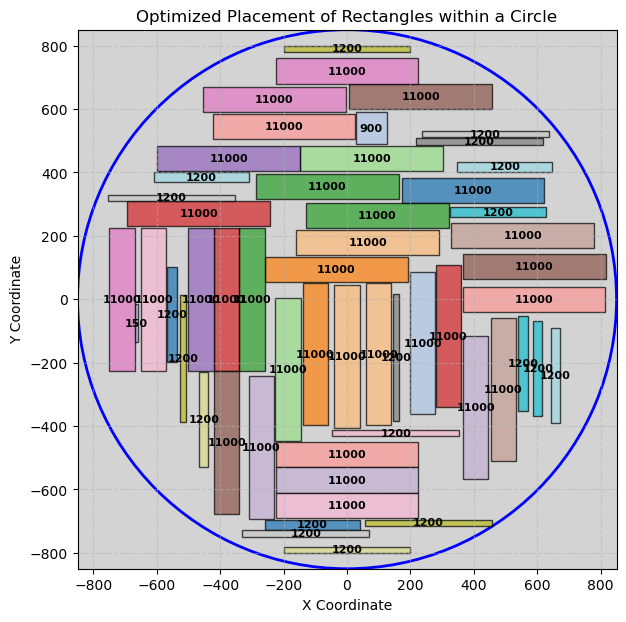

In [35]:
population_size = 100
number_of_generations = 100

rectangles = [
    (10, 120, 120),
    (120, 10, 150),
    (400, 20, 1200),
    (300, 30, 1200),
    (120, 120, 1200),
    (100, 100, 900),
    (450, 80, 11000)
]

circle_radius = 850

best_solution = genetic_algorithm(population_size, number_of_generations, rectangles, circle_radius)
print("Maksymalna wartość:", evaluate(best_solution, circle_radius))

plot_solution(best_solution, circle_radius)

<style>
  h1, h2, h3, h4 {
    color: #458dc8;
  }
</style>

# r800

Maksymalna wartość: 28400


C:\Users\zareb\AppData\Local\Temp\ipykernel_21028\785087615.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(individual))


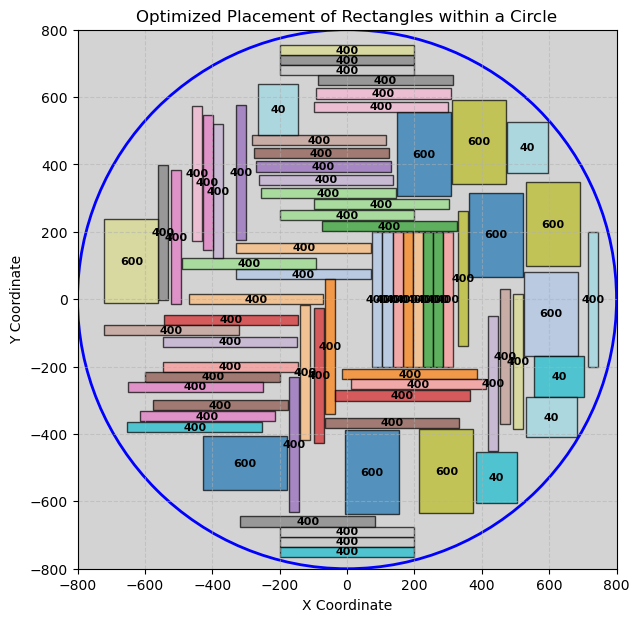

In [38]:
population_size = 200
number_of_generations = 200

rectangles = [
    (250, 120, 100),
    (320, 160, 500),
    (250, 160, 600),
    (150, 120, 40),
    (400, 30, 400)
]


circle_radius = 800

best_solution = genetic_algorithm(population_size, number_of_generations, rectangles, circle_radius)
print("Maksymalna wartość:", evaluate(best_solution, circle_radius))

plot_solution(best_solution, circle_radius)

<style>
  h1, h2, h3, h4 {
    color: #458dc8;
  }
</style>

# r1200

Maksymalna wartość: 31500


C:\Users\zareb\AppData\Local\Temp\ipykernel_21028\2183000057.py:155: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(individual))


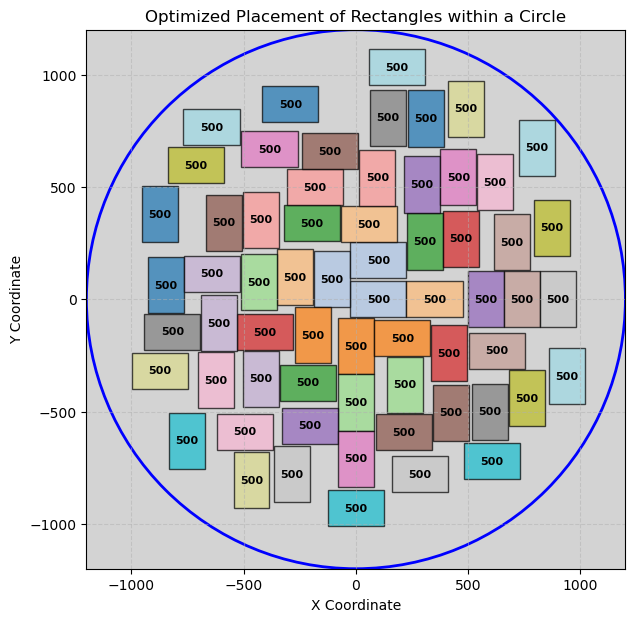

In [25]:
population_size = 100
number_of_generations = 100

rectangles = [
    (200, 120, 200),
    (200, 160, 300),
    (250, 160, 500),
    (100, 120, 40)
]


circle_radius = 1200

best_solution = genetic_algorithm(population_size, number_of_generations, rectangles, circle_radius)
print("Maksymalna wartość:", evaluate(best_solution, circle_radius))

plot_solution(best_solution, circle_radius)

<style>
  h1, h2, h3, h4 {
    color: #458dc8;
  }
</style>

# r1000

Maksymalna wartość: 25000


C:\Users\zareb\AppData\Local\Temp\ipykernel_21028\785087615.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(individual))


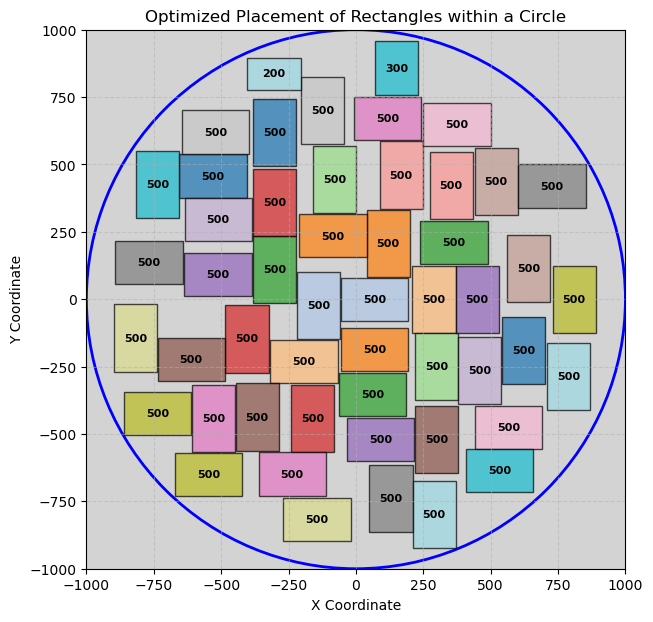

In [32]:
population_size = 200
number_of_generations = 100

rectangles = [
    (200, 120, 200),
    (200, 160, 300),
    (250, 160, 500),
    (100, 120, 40)
]

circle_radius = 1000

best_solution = genetic_algorithm(population_size, number_of_generations, rectangles, circle_radius)
print("Maksymalna wartość:", evaluate(best_solution, circle_radius))

plot_solution(best_solution, circle_radius)

<style>
  h1, h2, h3, h4 {
    color: #458dc8;
  }
</style>

# r1100

Maksymalna wartość: 31800


C:\Users\zareb\AppData\Local\Temp\ipykernel_21028\785087615.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(individual))


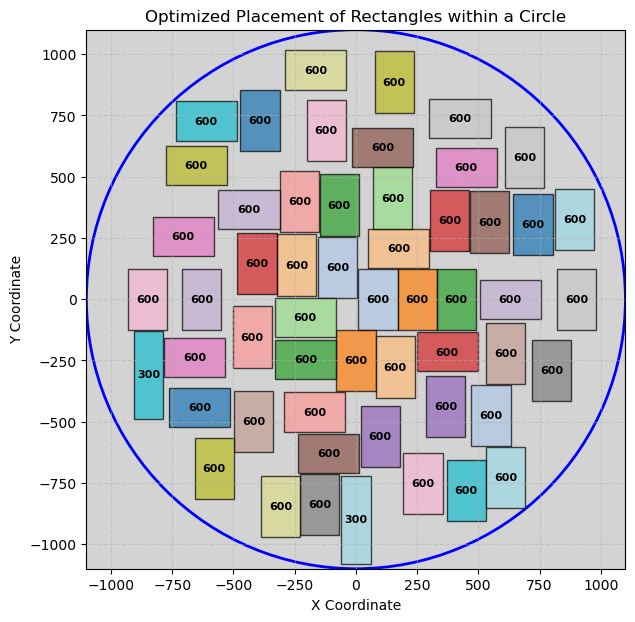

In [33]:
population_size = 200
number_of_generations = 100

rectangles = [
    (250, 120, 100),
    (120, 360, 300),
    (250, 160, 600),
    (150, 120, 40)
]

circle_radius = 1100

best_solution = genetic_algorithm(population_size, number_of_generations, rectangles, circle_radius)
print("Maksymalna wartość:", evaluate(best_solution, circle_radius))

plot_solution(best_solution, circle_radius)